In [ ]:
import tensorflow as tf    
tf.compat.v1.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from tensorflow.keras.layers import \
    BatchNormalization, Dropout, LayerNormalization, \
    Input, Conv1D, Activation, concatenate, Dense, Flatten, \
    GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, \
    LSTM, TimeDistributed, \
    Conv2D, MaxPool2D, GlobalMaxPool2D, MaxPooling2D, \
    PReLU, LeakyReLU, Bidirectional, ConvLSTM2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm as maxnorm
from tensorflow.keras.utils import plot_model, get_custom_objects
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.backend import sigmoid
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, time
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
#from tensorflow.keras.activations import gelu
import matplotlib.pyplot as plt
import argparse
from multiprocessing.dummy import Pool as ThreadPool

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import pandas as pd
from tensorflow.keras.backend import sigmoid
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def swish(x, beta = 1):
    # https://www.geeksforgeeks.org/ml-swish-function-by-google-in-keras/
    return (x * sigmoid(beta * x))
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.25)
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
def weighted_loss(y_true, y_pred):
    return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)

def image_convert(a):
    new = np.zeros((30, 30))
    for i in range(30):
        if int(a[i]*100)==0:
            d = 29
        elif int(a[i]*100)==100:
            d = 0
        else:
            d = 30-int(30-(1-a[i])*30)
            if d==30:
                d = 29
        new[d, i] = 1
    return new

get_custom_objects().update({'swish': swish})
get_custom_objects().update({'leaky_relu': leaky_relu})
get_custom_objects().update({"get_weighted_loss": get_weighted_loss})
get_custom_objects().update({"weighted_loss": weighted_loss})

In [ ]:
banana_X_train = pd.read_excel("veg_X_train.xlsx")
banana_X_val = pd.read_excel("veg_X_val.xlsx")
banana_Y_train = pd.read_excel("veg_Y_train.xlsx")
banana_Y_val = pd.read_excel("veg_Y_val.xlsx")

cols_name = [[y+'-'+str(x).rjust(2,"0") for x in range(1,31)] for y in ['RSV','上價中位數','下價中位數','中價中位數','交易量','平均價','雨量']]
cols_name_2 = [x for x in banana_X_train.columns.tolist() if '-' not in x]

train_X_num = banana_X_train[cols_name_2[1:]].values
val_X_num = banana_X_val[cols_name_2[1:]].values

train_Y_1 = banana_Y_train[[x for x in banana_Y_train.columns if '成本價格' in x]].values
val_Y_1 = banana_Y_val[[x for x in banana_Y_val.columns if '成本價格' in x]].values

train_X_lstm_1 = []
for i in range(len(cols_name)):
    tmp = banana_X_train[cols_name[i]].iloc[:,-7:]
    train_X_lstm_1.append(tmp)
train_X_lstm_1 = np.stack(train_X_lstm_1,axis=2)
val_X_lstm_1 = []
for i in range(len(cols_name)):
    tmp = banana_X_val[cols_name[i]].iloc[:,-7:]
    val_X_lstm_1.append(tmp)
val_X_lstm_1 = np.stack(val_X_lstm_1,axis=2)

train_X_lstm_2 = []
for i in range(len(cols_name)):
    tmp_all = []
    tmp = banana_X_train[cols_name[i]].iloc[:,-13:]
    for j in range(7):
        tmp_1 = tmp.iloc[:,j:j+7]
        tmp_all.append(tmp_1)
    tmp_all = np.stack(tmp_all,axis=2)
    train_X_lstm_2.append(tmp_all)
train_X_lstm_2 = np.stack(train_X_lstm_2,axis=3)

val_X_lstm_2 = []
for i in range(len(cols_name)):
    tmp_all = []
    tmp = banana_X_val[cols_name[i]].iloc[:,-13:]
    for j in range(7):
        tmp_1 = tmp.iloc[:,j:j+7]
        tmp_all.append(tmp_1)
    tmp_all = np.stack(tmp_all,axis=2)
    val_X_lstm_2.append(tmp_all)
val_X_lstm_2 = np.stack(val_X_lstm_2,axis=3)

train_X_lstm_4 = np.stack([np.stack([image_convert(x) for x in banana_X_train[cols_name[y]].values]) for y in range(len(cols_name))], axis=3)
val_X_lstm_4 = np.stack([np.stack([image_convert(x) for x in banana_X_val[cols_name[y]].values]) for y in range(len(cols_name))], axis=3)

data_X = {'Conv1D':[train_X_lstm_1, val_X_lstm_1],
          'Vanilla':[train_X_lstm_1, val_X_lstm_1],
          'Stacked':[train_X_lstm_1, val_X_lstm_1],
          'Bidirectional':[train_X_lstm_1, val_X_lstm_1],
          'Conv1D_LSTM':[train_X_lstm_2, val_X_lstm_2],
          'Conv2D_1':[train_X_lstm_2, val_X_lstm_2],
          'Conv2D_2':[train_X_lstm_4, val_X_lstm_4]}

In [ ]:
        train_Y_1 = banana_Y_train[[x for x in banana_Y_train.columns if '成本價格' in x]].values
        val_Y_1 = banana_Y_val[[x for x in banana_Y_val.columns if '成本價格' in x]].values

        # build model
        model1_in, model1_out = conv1d_model(data_X["Conv1D_LSTM"][0],
                                             Normalize_rate = 0, 
                                             activation_conv = 'relu', 
                                             activation_dense = 'relu')

In [ ]:
model = load_model('weights_accuracy.hdf5',compile=False)

In [ ]:
import shap
explainer = shap.DeepExplainer(model, [data_X["Conv1D_LSTM"][0],train_X_num], learning_phase_flags = None)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
a = explainer.shap_values([data_X["Conv1D_LSTM"][1][:100],val_X_num[:100]])

In [ ]:
banana_X_train.columns.tolist()

In [ ]:
, feature_names = ['RSV','上價中位數','下價中位數','中價中位數','交易量','平均價','雨量']

In [ ]:
shap.summary_plot(a[0][0][:,:,6,:])

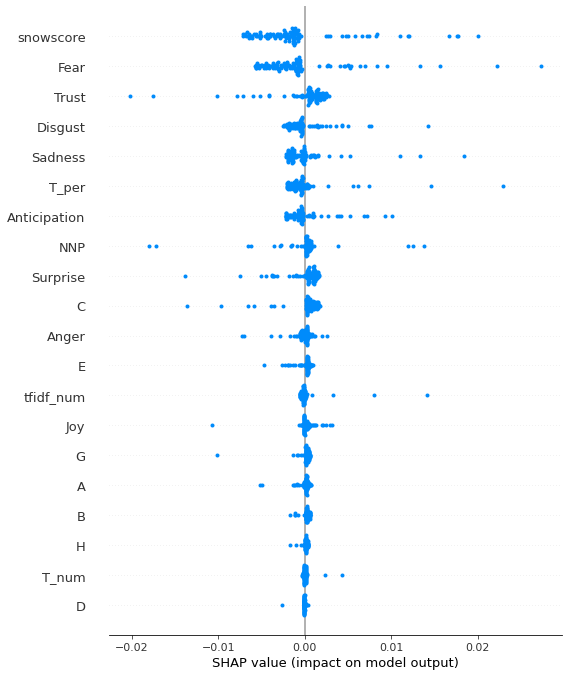

In [ ]:
shap.summary_plot(a[0][1], feature_names = banana_X_val[cols_name_2[1:]].columns.tolist())